In [1]:
import warnings
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
#https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e

In [2]:
# load walmart ($wmt) historical stock data
wmt = pd.read_csv('C:\\Users\\ankur\\Downloads\\WMT.csv')
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.023768,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.023678,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.023408,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.023408,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.023047,870400


In [3]:
wmt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11815 entries, 0 to 11814
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11815 non-null  object 
 1   Open       11815 non-null  float64
 2   High       11815 non-null  float64
 3   Low        11815 non-null  float64
 4   Close      11815 non-null  float64
 5   Adj Close  11815 non-null  float64
 6   Volume     11815 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 646.3+ KB


In [4]:
wmt.describe()


,Open,High,Low,Close,Adj Close,Volume
count,11815.000000,11815.000000,11815.000000,11815.000000,11815.000000,1.181500e+04
mean,29.942336,30.226543,29.658511,29.948090,24.052813,7.510762e+06
std,29.802418,30.051176,29.566506,29.811830,26.403796,6.327371e+06
min,0.015625,0.015625,0.014404,0.015625,0.005798,0.000000e+00
25%,1.265625,1.281250,1.253906,1.265625,0.513472,3.753600e+06
50%,13.718750,13.843750,13.562500,13.687500,8.964169,6.263200e+06
75%,54.000000,54.570000,53.500000,54.000000,40.389094,9.515000e+06
max,111.489998,112.220001,111.029999,111.599998,111.599998,1.318336e+08


In [5]:
#  new dataframe with date and adjusted closing price
wmt = wmt[['Date','Adj Close']]
wmt.head()

,Date,Adj Close
0,1972-08-25,0.023768
1,1972-08-28,0.023678
2,1972-08-29,0.023408
3,1972-08-30,0.023408
4,1972-08-31,0.023047


In [6]:
# adjust column names for prophet compliance
wmt.columns = ['ds','y']
wmt.head()

,ds,y
0,1972-08-25,0.023768
1,1972-08-28,0.023678
2,1972-08-29,0.023408
3,1972-08-30,0.023408
4,1972-08-31,0.023047


In [7]:
# convert dates from string to datetime
wmt.ds = pd.to_datetime(wmt.ds)

# display adjustments
wmt.tail()

,ds,y
11810,2019-06-26,110.160004
11811,2019-06-27,110.099998
11812,2019-06-28,110.489998
11813,2019-07-01,110.620003
11814,2019-07-02,111.599998


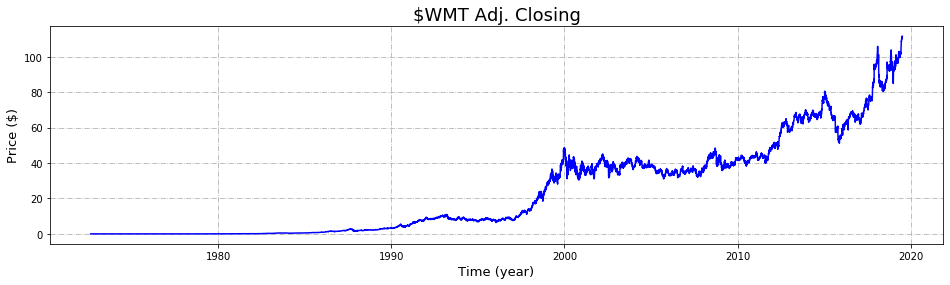

In [8]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(wmt.ds, wmt.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


              ds
13635 2024-06-26
13636 2024-06-27
13637 2024-06-28
13638 2024-06-29
13639 2024-06-30


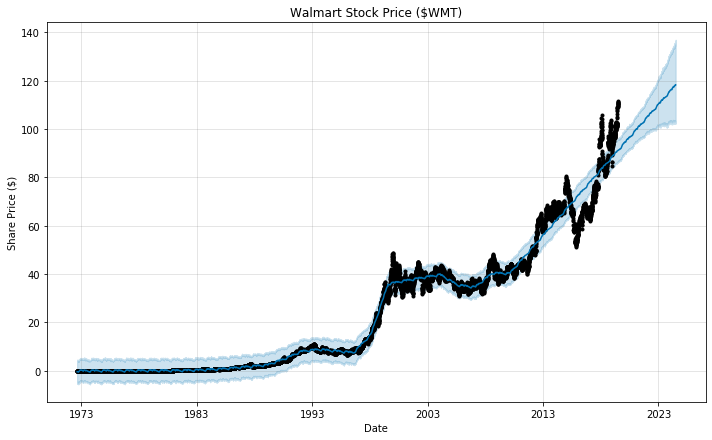

In [9]:
# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False,)
# fit $wmt data to model
prophet.fit(wmt)
# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=365*5, freq='D')
print(build_forecast.tail())
# forecast future df with model
forecast = prophet.predict(build_forecast)

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
plt.show()

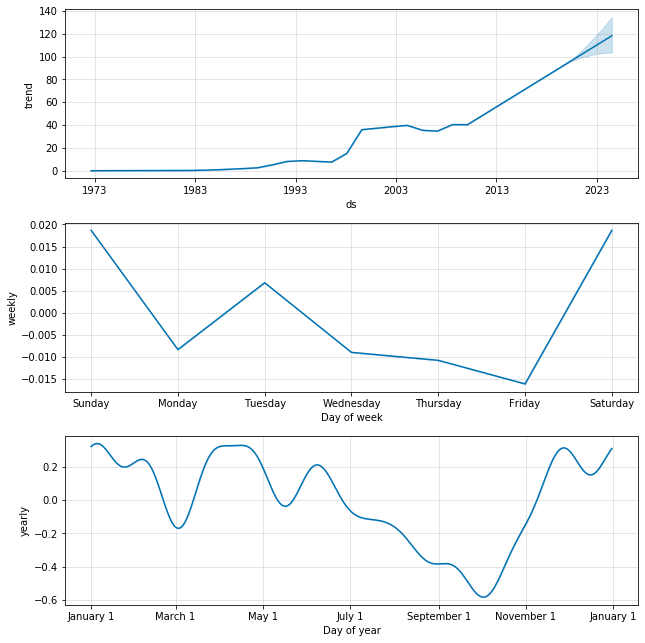

In [10]:
# tell us more about the forecast
components = prophet.plot_components(forecast)

In [11]:
# narrow selection to dates past initial dataframe
future_preds = forecast.loc[forecast.ds>'2019-07-02']
# select date, prediction, lower and upper limits 
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
# display some predictions
future_preds.sample(5)

,ds,yhat,yhat_lower,yhat_upper
12762,2022-02-04,105.477551,98.725730,112.714892
12473,2021-04-21,101.271916,95.840568,107.041071
13488,2024-01-31,116.238946,103.363731,131.618982
13203,2023-04-21,112.102965,101.720994,123.694757
13479,2024-01-22,116.091998,102.547575,131.495840


In [12]:
# cross validate 1 year every half year at 30 years
wmt_cv = cross_validation(prophet, initial='10950 days', period='180 days', horizon = '365 days')
wmt_cv.head()


INFO:fbprophet:Making 33 forecasts with cutoffs between 2002-09-24 00:00:00 and 2018-07-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-09-25,46.394770,43.143582,49.532909,37.005474,2002-09-24
1,2002-09-26,46.422246,43.363856,49.450904,38.193005,2002-09-24
2,2002-09-27,46.416661,43.438717,49.377594,36.436600,2002-09-24
3,2002-09-30,46.517164,43.548984,49.680396,35.014393,2002-09-24
4,2002-10-01,46.555739,43.513531,49.760504,36.770809,2002-09-24


In [13]:
#measure performance
wmt_pm = performance_metrics(wmt_cv)

In [14]:
# final accuracy
wmt_pm.tail(3)

,horizon,mse,rmse,mae,mape,mdape,coverage
326,363 days,111.649060,10.566412,8.958890,0.168026,0.162288,0.145783
327,364 days,112.721339,10.617031,8.990406,0.168447,0.163226,0.145469
328,365 days,114.644458,10.707215,9.066014,0.169391,0.164967,0.140745


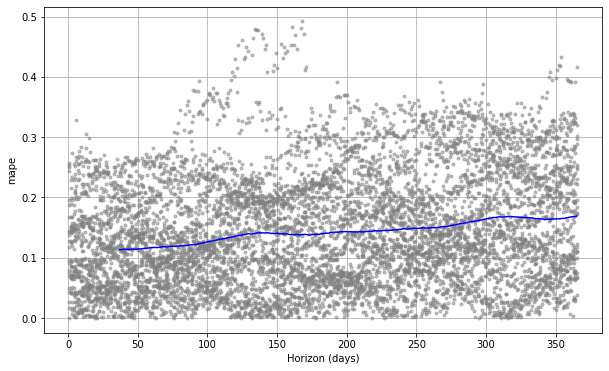

In [15]:
# visualize mape across horizon (continued sort)
fig = plot_cross_validation_metric(wmt_cv, metric='mape')

In [16]:
# where did prophet identify changepoints
prophet.changepoints

378    1974-02-28
756    1975-08-27
1134   1977-02-24
1512   1978-08-24
1890   1980-02-22
2268   1981-08-21
2646   1983-02-17
3024   1984-08-16
3402   1986-02-14
3780   1987-08-14
4158   1989-02-10
4536   1990-08-10
4915   1992-02-10
5293   1993-08-09
5671   1995-02-06
6049   1996-08-05
6427   1998-02-03
6805   1999-08-04
7183   2001-02-01
7561   2002-08-08
7939   2004-02-09
8317   2005-08-09
8695   2007-02-09
9073   2008-08-11
9451   2010-02-10
Name: ds, dtype: datetime64[ns]